In [2]:
from pyspark.sql import SparkSession

# Créer une session Spark
spark = SparkSession.builder.appName("Detection du fraude").getOrCreate()

# Lire le fichier CSV en tant que DataFrame
data_detection = spark.read.csv("creditcarddata.csv", header=True, inferSchema=True)


In [3]:
# Afficher les noms de colonnes
print(data_detection.columns)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


    "step" : Le temps écoulé en heures entre la transaction la plus ancienne et la transaction actuelle.
    "type" : Le type de transaction, soit 'CASH-IN', 'CASH-OUT', 'DEBIT', 'PAYMENT' ou 'TRANSFER'.
    "amount" : Le montant de la transaction.
    "nameOrig" : Le nom du compte d'origine.
    "oldbalanceOrg" : Le solde initial du compte d'origine avant la transaction.
    "newbalanceOrig" : Le solde du compte d'origine après la transaction.
    "nameDest" : Le nom du compte de destination.
    "oldbalanceDest" : Le solde initial du compte de destination avant la transaction.
    "newbalanceDest" : Le solde du compte de destination après la transaction.
    "isFraud" : Indique si la transaction est frauduleuse (1) ou non (0).
    "isFlaggedFraud" : Indique si la transaction a été signalée comme frauduleuse (1) ou non (0). Une transaction est signalée comme frauduleuse si elle satisfait à certaines conditions, notamment si elle est de type "TRANSFER" et que le montant dépasse une certaine valeur.

In [4]:
num_rows = data_detection.count()
num_cols = len(data_detection.columns)
print("Shape: ({}, {})".format(num_rows, num_cols))


Shape: (6362620, 11)


In [5]:
# Afficher les 20 premières lignes du DataFrame
data_detection.show(20)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [6]:
from pyspark.sql.functions import isnull, sum, when

# Vérifier les valeurs nulles pour chaque colonne
data_detection.select([sum(when(isnull(c), 1).otherwise(0)).alias(c) for c in data_detection.columns]).show()


+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [7]:
# Afficher les types de données des colonnes
data_detection.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'int')]

In [8]:
# Afficher des statistiques descriptives pour toutes les colonnes numériques
data_detection.describe().show()

+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|    oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|          6362620|    6362620|          6362620|           6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    null|179861.9035491287|       null|833883.1040744764| 855113.6685785812|       null|1100701.6665196533|1224996.3982019224|0.001290820448180152| 2.51468734577894E-6|
| stddev|142.33

In [9]:
from pyspark.sql.functions import count

# Grouper les données par la variable isFraud
grouped_df = data_detection.groupBy('isFraud')

# Compter le nombre de fraudes et de transactions normales
count_df = grouped_df.agg(count('*').alias('count'))

# Afficher les résultats
count_df.show()


+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Comptage des fraudes
fraud_count = data_detection.filter(data_detection.isFraud == 1).count()

# Comptage des non-fraudes
not_fraud_count = data_detection.filter(data_detection.isFraud == 0).count()


In [11]:
# Création d'un DataFrame pandas avec les données de comptage
fraud_data = pd.DataFrame({'Fraud': fraud_count, 'Not Fraud': not_fraud_count}, index=['Count'])


In [12]:
fraud_data

,Fraud,Not Fraud
Count,8213,6354407


In [13]:
fraud_data = pd.DataFrame({
    'Label': ['Fraud', 'Not Fraud'],
    'Count': [fraud_count, not_fraud_count]
})


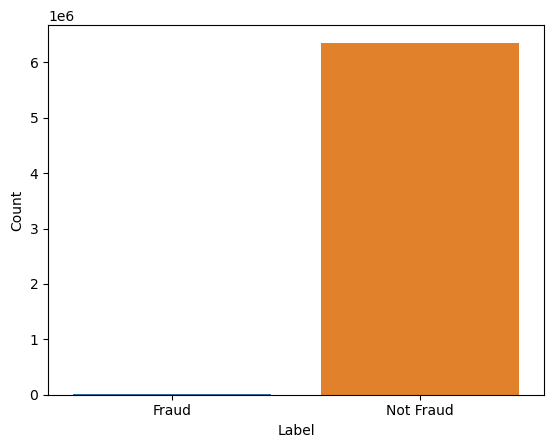

In [14]:
sns.barplot(x='Label', y='Count', data=fraud_data)
plt.ylabel('Count')
plt.show()


+--------+-------+
|    type|  count|
+--------+-------+
|CASH_OUT|2237500|
| PAYMENT|2151495|
| CASH_IN|1399284|
|TRANSFER| 532909|
|   DEBIT|  41432|
+--------+-------+



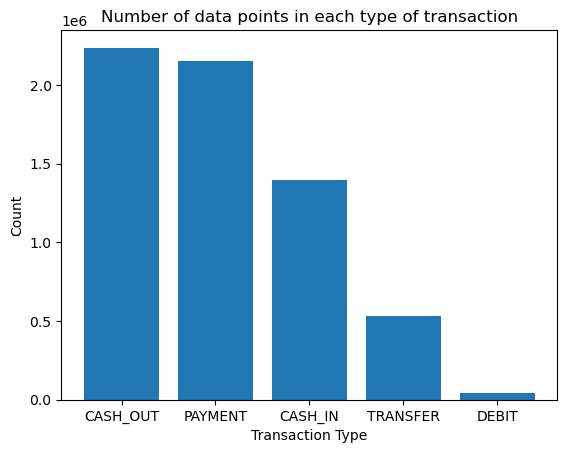

In [15]:
# Count number of data point in each type of transaction
type_counts = data_detection.groupBy('type').agg(count('type').alias('count')).orderBy('count', ascending=False)
type_counts.show()

# Plot a bar graph to visualize the count of each type of transaction
fig, ax = plt.subplots()
ax.bar(type_counts.toPandas()['type'], type_counts.toPandas()['count'])
ax.set_xlabel('Transaction Type')
ax.set_ylabel('Count')
ax.set_title('Number of data points in each type of transaction')
plt.show()


In [16]:
from pyspark.sql.functions import sum

# Group by type and sum the isFraud and isFlaggedFraud columns
df_grouped = data_detection.groupBy('type').agg(sum('isFraud').alias('TotalFraud'), sum('isFlaggedFraud').alias('TotalFlaggedFraud'))

# Show the resulting DataFrame
df_grouped.show()


+--------+----------+-----------------+
|    type|TotalFraud|TotalFlaggedFraud|
+--------+----------+-----------------+
|TRANSFER|      4097|               16|
| CASH_IN|         0|                0|
|CASH_OUT|      4116|                0|
| PAYMENT|         0|                0|
|   DEBIT|         0|                0|
+--------+----------+-----------------+



La fraude ne se produit que dans 2 types de transactions :
TRANSFERT et CASH_OUT
=>Le nombre de VIREMENTS frauduleux = 4097
=>Le nombre de CASH_OUTs frauduleux = 4116.


In [20]:
from pyspark.sql.functions import col

# Création d'une copie du DataFrame df
data = data_detection.select([col(c).alias(c) for c in data_detection.columns])


In [30]:
# Obtention des valeurs uniques de la colonne "gender"
unique_genders = data.select(col("nameOrig")).distinct()

# Affichage des valeurs uniques
unique_genders.show()


+-----------+
|   nameOrig|
+-----------+
| C100021340|
|C1000262126|
|C1000502024|
|C1000507192|
|C1000547990|
|C1000570608|
|C1000809646|
|C1001563842|
|C1001939515|
|C1003046006|
|C1003046870|
|C1003149650|
|C1003164154|
|C1003434016|
|  C10037801|
|C1004267694|
|C1004511598|
|C1005206689|
|C1005557457|
|C1005826701|
+-----------+
only showing top 20 rows



In [34]:
from pyspark.sql.functions import when

data = data.withColumn('TRANSFER', when(data['type'] == 'TRANSFER', 1).otherwise(0))
data = data.withColumn('CASH_OUT', when(data['type'] == 'CASH_OUT', 1).otherwise(0))


In [ ]:
# Merchant flag for source and dist
data['OrigC']=data['nameOrig'].withColumn(lambda x: 1 if str(x).find('C')==0 else 0)
data['DestC']=data['nameDest'].withColumn(lambda x: 1 if str(x).find('C')==0 else 0)

# methode smote
